## install data

source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

data dictionary: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [2]:
# !pip install wget
import wget
import os

os.makedirs('data')
green_jan_2021 = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
green_feb_2021 = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

wget.download(green_jan_2021, "data/green_jan_2021.parquet")
wget.download(green_feb_2021, "data/green_feb_2021.parquet")

'data/green_feb_2021.parquet'

## libraries

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

## Read in data

In [4]:
# !pip install pyarrow
df = pd.read_parquet('data/green_jan_2021.parquet')

In [5]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


## Preprocessing

In [6]:
# parse dates
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

### Calculate Trip duration

In [7]:
# get trip duration
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

# convert to minutes
df.duration = df.duration.apply(lambda x : x.total_seconds() / 60)

### duration distribution

In [8]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [9]:
df.duration.describe(percentiles = [0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [10]:
# filter duration 
df = df.loc[(df.duration >= 1) & (df.duration <= 60)]

## Feature selection

In [11]:
# filter necessary columns

cat = ['PULocationID', 'DOLocationID']
num = ['trip_distance']

### Dictionary vectorizer

In [13]:
# turn categorical to object type first
df[cat] = df[cat].astype(str)

/tmp/ipykernel_5114/4114848577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat] = df[cat].astype(str)


In [14]:
# turn data frame into dictionary
df[cat + num].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [15]:
train_dict = df[cat + num].to_dict(orient='records')

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [17]:
dv.feature_names_[:5]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102']

In [18]:
target =  'duration'
y_train = df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

## Baseline Model

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)

<AxesSubplot:ylabel='Count'>

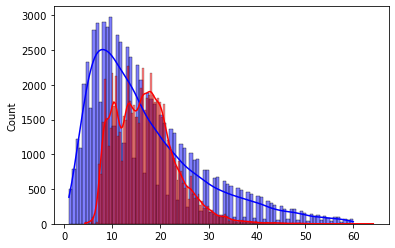

In [21]:
sns.histplot(y_train, label='train', kde=True, color='blue')
sns.histplot(y_pred, label='prediction', kde=True, color='red')

In [22]:
mean_squared_error(y_train, y_pred, squared=False)

9.775463820547285

our model is wrong on average by 9.77 minutes

In [40]:
def read_preprocess(file_name) -> pd.DataFrame:

    df = pd.read_parquet(file_name)
    
    # parse dates
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    # get trip duration
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x : x.total_seconds() / 60)

    df = df.loc[(df.duration >= 1) & (df.duration <= 60)]

    cat = ['PULocationID', 'DOLocationID']
    df[cat] = df[cat].astype(str)

    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']

    return df

### use validation dataset

In [51]:
df_train = read_preprocess("data/green_jan_2021.parquet")
df_val = read_preprocess("data/green_feb_2021.parquet")

len(df_train), len(df_val)

(73908, 61921)

In [52]:
# cat = ['PULocationID', 'DOLocationID']
cat = ['PU_DO']
num = ['trip_distance']

dv = DictVectorizer()

train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [55]:
target =  'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [62]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.479618227604778

In [63]:
lr_lasso = Lasso(alpha=0.001)
lr_lasso.fit(X_train, y_train)

y_pred = lr_lasso.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [64]:
lr_ridge = Ridge(alpha=0.001)
lr_ridge.fit(X_train, y_train)

y_pred = lr_ridge.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.342565604854506

## save model

In [66]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)